# Car fuel economy with weather data

__What further insights can be gained by adding information on weather conditions to the fuel economy data?__

__Can we accurately predict what the fuel economy will be given the temperature, wind, and tire season?__

## Section 1: loading, cleaning, and merging of data 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import datetime as dt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.svm import SVR
import statsmodels.api as sm

In [2]:
## Read in mileage data and local weather data

Econ = pd.read_excel("Focus_svt_log.ods", engine="odf")

Weather = pd.read_csv('DET_weather.csv')


In [3]:
## Add columns for MPG and MPG 4-point average, calculate each, and remove outliers

Econ['mpg'] = [0.0] * Econ.shape[0]
Econ['mpg_4'] = [0.0] * Econ.shape[0]

In [4]:
for i in range(1,Econ.shape[0]):
  Econ.loc[i,'mpg'] = ((Econ.loc[i,'miles'] - Econ.loc[i-1,'miles'])/Econ.loc[i,'gallons']) 

In [5]:
if any(Econ['mpg'] >= 40):
  Econ.drop(index = Econ[Econ['mpg'] >= 40].index, inplace = True)

if any(Econ['mpg'] <=5):
  Econ.drop(index = Econ[Econ['mpg'] <= 5].index, inplace = True)

Econ = Econ.reset_index()



In [6]:
for i in range(1,Econ.shape[0]-2):
  Econ.loc[i,'mpg_4'] = (Econ.loc[i+2,'mpg'] + Econ.loc[i-1,'mpg'] + Econ.loc[i,'mpg'] + Econ.loc[i+1,'mpg'])/4 


In [7]:
if any(Econ['mpg_4'] >= 40):
  Econ.drop(index = Econ[Econ['mpg_4'] >= 40].index, inplace = True)

if any(Econ['mpg_4'] <= 5):
  Econ.drop(index = Econ[Econ['mpg_4'] <= 5].index, inplace = True)

Econ = Econ.reset_index()


In [8]:
# Select data from the year 2017, then use year, month, and day to create a single date column

# Only keep data from 2017 
Econ17 = Econ[Econ['year'] == 2017] #.reset_index()

# Convert to a single date column
Econ17['date'] = pd.to_datetime(Econ17[['year', 'month','day']])


/tmp/ipykernel_36294/49773053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Econ17['date'] = pd.to_datetime(Econ17[['year', 'month','day']])


Create another column for tire season

In [9]:


def month2tire_season(month):
  Tire_season = {
  1:'Winter',
  2:'Winter',
  3:'Winter',
  4:'Summer',
  5:'Summer',
  6:'Summer',
  7:'Summer',
  8:'Summer',
  9:'Summer',
  10:'Winter',
  11:'Winter',
  12:'Winter'}
  
  return Tire_season[month]
  
  
Econ17['tire_season'] = Econ17['month'].apply(month2tire_season)

/tmp/ipykernel_36294/2739849787.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Econ17['tire_season'] = Econ17['month'].apply(month2tire_season)


Merge NOAA weather and fuel economy data  

In [10]:
Weather['date'] =  pd.to_datetime(Weather['DATE'])

Econ17.sort_values('date', inplace = True)

Econ_w = Econ17.merge(Weather, how = 'left', on = 'date')

/tmp/ipykernel_36294/3198699868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Econ17.sort_values('date', inplace = True)


In [11]:
## Calculate the approximate daily average temperature by taking the mean daily minimum and maximum temperature. 
## Then look for missing temperature and wind data and replace missing values with the monthly mean. 

Econ_w['TMID'] =  Econ_w[['TMAX', 'TMIN']].mean(axis=1)


In [12]:
Econ_w[Econ_w['TMID'].isna()]
## Both missing values are in November.

## November only has missing temperature data for those days, the midpoint temperature should be between 40.5 and 36.5.
## We'll fill in the average temperature of 38.5 on the surrounding days.
# Econ_w[Econ_w['month'] == 11]

Econ_w['TMID'] = Econ_w['TMID'].fillna(38.5)

## Check November again 
#Econ_w[Econ_w['month'] == 11]

In [13]:
Econ_w[Econ_w['AWND'].isna()]
## There's a missing wind value in August for average wind speed
## Let's replace it with the mean wind speed for the month. 
Aug_w = Econ_w[Econ_w['month'] == 8].AWND.mean()

## Check to see if the mean wind speed for the month looks like a reasonable value for that date
## Weather[Weather['date'].dt.month == 8]

## Now replace the missing value
Econ_w['AWND'] = Econ_w['AWND'].fillna(Aug_w)


In [14]:
## Convert tire season to a boolean value, equal to 'winter tire season' 

Econ_w['tire_season_w'] = pd.to_numeric(Econ_w['tire_season'] == 'Winter')


## Section 2: prediction of fuel economy

First, we'll try to predict fuel economy using linear regression with tire season, temperature, and wind as predictors.

In [15]:
## Read in weather data from 2016. Then merge weather data and fuel economy data. 

Weather_16 = pd.read_csv('DET_weather_16.csv')

Weather_16['date'] =  pd.to_datetime(Weather_16['DATE'])

Econ16 = Econ[Econ['year'] == 2016] #.reset_index()

Econ16['date'] = pd.to_datetime(Econ16[['year', 'month','day']])

Econ16.sort_values('date')

Econ16['tire_season'] = Econ16['month'].apply(month2tire_season)

Econ16_w = Econ16.merge(Weather_16, how = 'left', on = 'date')

Econ16_w['tire_season_w'] = pd.to_numeric(Econ16_w['tire_season'] == 'Winter')

Econ16_w['TMID'] =  Econ16_w[['TMAX', 'TMIN']].mean(axis=1)

## check the merge

#Econ16_w.head()

#Econ16_w[Econ16_w['TMID'].isna()] #none
#Econ16_w[Econ16_w['AWND'].isna()] #none

/tmp/ipykernel_36294/1458506721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Econ16['date'] = pd.to_datetime(Econ16[['year', 'month','day']])
/tmp/ipykernel_36294/1458506721.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Econ16['tire_season'] = Econ16['month'].apply(month2tire_season)


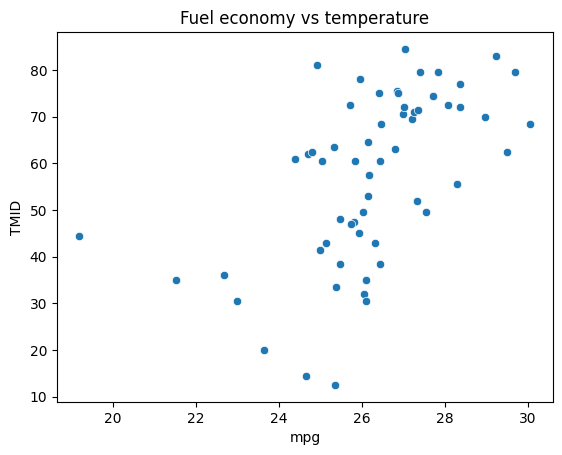

np.float64(0.5567170687790052)

In [16]:
plot = sns.scatterplot(data = Econ16_w, x = 'mpg', y = 'TMID')
plt.title('Fuel economy vs temperature')
plt.show()

np.corrcoef(Econ16_w['mpg'], Econ16_w['TMID'])[0,1]

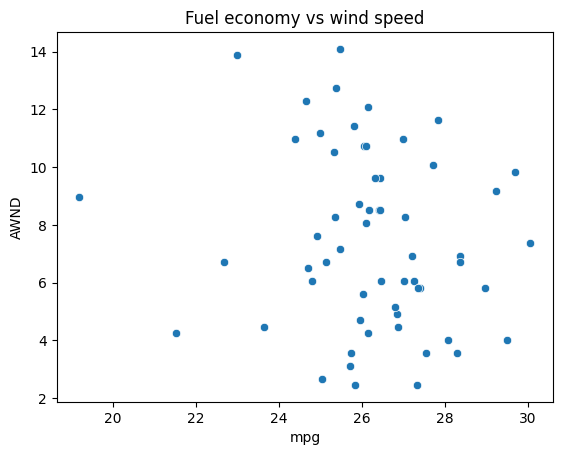

np.float64(-0.15208677756924247)

In [17]:
plot = sns.scatterplot(data = Econ16_w, x = 'mpg', y = 'AWND')
plt.title('Fuel economy vs wind speed')
plt.show()

np.corrcoef(Econ16_w['mpg'], Econ16_w['AWND'])[0,1]

From these plots, there does appear to be a positive correlation between temperature and fuel economy and a negative correlation between wind speed and fuel economy. So we'd expect to see a negative association between wind speed and fuel economy, as well as a positive association between fuel economy and temperature. 

In [18]:
lm = LinearRegression()

wt_16 = Econ16_w[['tire_season_w','TMID','AWND']].to_numpy(dtype = 'float64')
mpg_16 = Econ16_w['mpg'].to_numpy(dtype = 'float64') 

model_t = lm.fit(X=wt_16,y=mpg_16)

model_s = sm.OLS(endog=mpg_16, exog=sm.add_constant(wt_16))

wt_17 = Econ_w[['tire_season_w','TMID','AWND']].to_numpy(dtype = 'float64')
mpg_17 = Econ_w['mpg'].to_numpy(dtype = 'float64') 

print(f'model r_sq',model_t.score(X=wt_16,y=mpg_16))

mpg_pred = model_t.predict(wt_17)
print(f'Coeficients for tire season, temperature, wind: {model_t.coef_}')
print(f'observed vs. predicted mpg correleation: {round(np.corrcoef(mpg_17, mpg_pred)[0,1],3)}')
fit_model_s = model_s.fit()
print(f'p-values for tire season, temperature, and wind: {fit_model_s.pvalues[1:4]}')
print(f'R^2 value: {fit_model_s.rsquared}')
# print(f'coef values: {fit_model_s.params[1:4]}') # check if OLS coefficents match
print(f'AIC value: {fit_model_s.aic}')

model r_sq 0.31317170827422525
Coeficients for tire season, temperature, wind: [0.33182113 0.06529047 0.00730162]
observed vs. predicted mpg correleation: 0.424
p-values for tire season, temperature, and wind: [0.61339016 0.000928   0.92106201]
R^2 value: 0.31317170827422514
AIC value: 227.78093804106445


Now let's look at the coefficients of the model. 

Tire season (given temperature and wind) is associated with a 0.332 MPG increase when using winter tires.

Temperature (given tire season and wind) is associated with a 0.0653 MPG increase for every 1-degree F increase in temperature.

Wind (given tire season and temperature) is associated with a 0.0073 MPG increase for every 1-MPH increase in wind speed. 

Seeing wind speed have little effect on fuel economy is surprising, as both crosswinds and headwinds should decrease fuel economy. It is also questionable that winter tires are beneficial for fuel economy, as they're often heavier and have more rolling resistance than summer tires. Only temperature, given tire season and wind speed, is significantly associated with fuel economy. However, I'd still recommend keeping wind speed in the model as its potential effect on fuel economy can be justified because of its effect on fuel economy. 

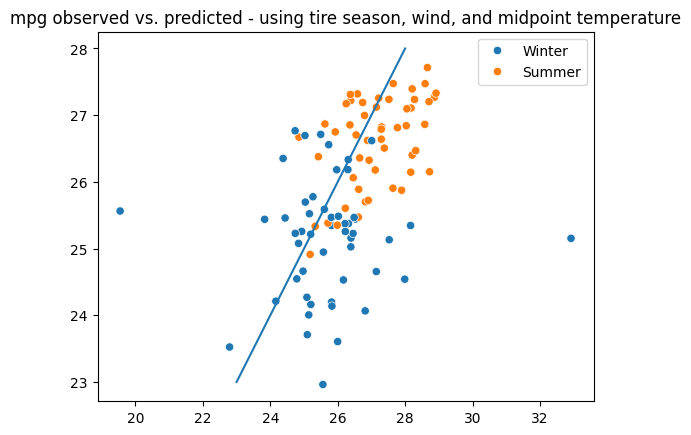

In [19]:
plot = sns.scatterplot(x=mpg_17,y=mpg_pred, hue=Econ_w['tire_season'])
plot = sns.lineplot(x=range(23,29), y=range(23,29))
plt.title('mpg observed vs. predicted - using tire season, wind, and midpoint temperature')
plt.show()
plt.close()

In [20]:
wot_16 = Econ16_w[['TMID','AWND']].to_numpy()
#mpg_16 = Econ16_w['mpg'] 

model = lm.fit(wot_16,mpg_16)
print(f'model r_sq',model.score(wot_16,mpg_16))

wot_17 = Econ_w[['TMID','AWND']].to_numpy()
#mpg_17 = Econ_w['mpg'] 

mpg_pred = model.predict(wot_17)
print(f'Coefficients for temperature and wind',model.coef_)
print(f'observed vs. predicted mpg correlation:',round(np.corrcoef(Econ_w['mpg'], mpg_pred)[0,1],3))

model r_sq 0.30994733716550826
Coefficients for temperature and wind [0.05808802 0.00238537]
observed vs. predicted mpg correlation: 0.449


Compared to the OLS model including tire season, the coefficent for temperature has decreased slightly from 0.0653 to 0.0581. Whereas the coefficient for wind has remained mostly unchanged, from 0.0073 to 0.0024. 

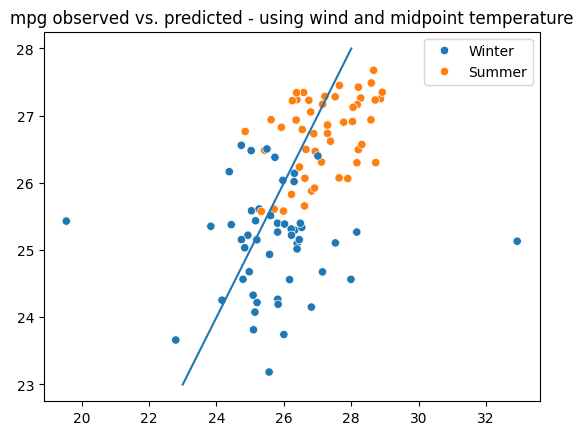

In [21]:
plot = sns.scatterplot(x=mpg_17,y=mpg_pred, hue=Econ_w['tire_season'])
plot = sns.lineplot(x=range(23,29), y=range(23,29))
plt.title('mpg observed vs. predicted - using wind and midpoint temperature')
plt.show()
plt.close()

In [22]:
print(f'Winter tire fuel economy',round(np.mean(Econ_w[Econ_w['tire_season'] == 'Winter'].mpg),2))

print(f'Summer tire fuel economy',round(np.mean(Econ_w[Econ_w['tire_season'] == 'Summer'].mpg),2))

Winter tire fuel economy 25.71
Summer tire fuel economy 27.15


In [23]:
## X and y variables for model prediction testing
## 'model' is the OLS model without tire season

#X = Econ_w[['TMID','AWND']].to_numpy()
#y = Econ_w['mpg'] 

model = lm.fit(wot_16,mpg_16)

mpg_pred = model.predict(wot_17)
print(f'Coeficients for temperature and wind',model.coef_)

print(f'model score:',model.score(wot_17,mpg_17))

delta = abs(mpg_pred-mpg_17)

mpg_sd = np.std(mpg_17)

print(f'mpg standard deviation',mpg_sd)

print(f'proportion of predictions within 1 standard deviation from the mean:', sum(delta < mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 2 standard deviations from the mean:', sum(delta < 2 * mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 3 standard deviations from the mean:',sum(delta < 3 * mpg_sd)/Econ_w.shape[0])

Coeficients for temperature and wind [0.05808802 0.00238537]
model score: 0.03882313210489707
mpg standard deviation 1.5585660573920277
proportion of predictions within 1 standard deviation from the mean: 0.7766990291262136
proportion of predictions within 2 standard deviations from the mean: 0.970873786407767
proportion of predictions within 3 standard deviations from the mean: 0.9805825242718447


77.7% of the predictions are within 1 standard deviation of the actual value. Let's plot the observed vs. predicted mpg to see if that offers any insight. 

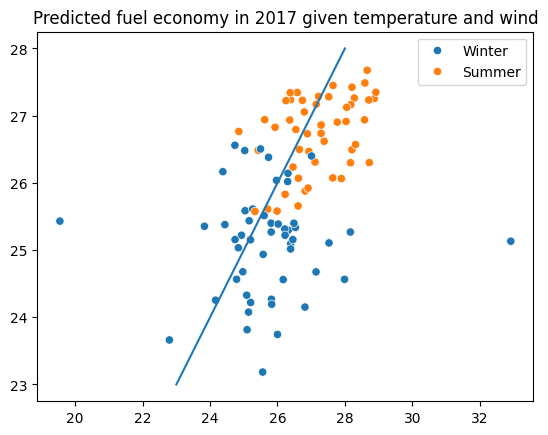

In [24]:
sns.scatterplot(x = mpg_17, y = mpg_pred, hue = Econ_w['tire_season'])
plot = sns.lineplot(x=range(23,29), y=range(23,29))
plt.title('Predicted fuel economy in 2017 given temperature and wind')
plt.show()
plt.close()

The OLS model that only includes temperature and wind seems to perform reasonable well. Perhaps adding tire season will improve the model further. 

In [25]:

#X = Econ_w[['tire_season_w','TMID','AWND']].to_numpy()
#y = Econ_w['mpg'] 

model_t = lm.fit(wt_16,mpg_16)

mpg_pred = model_t.predict(wt_17)
print(f'Coeficients for temperature and wind',model_t.coef_)

# print(model_t.score(X,y))

# np.corrcoef(mpg_pred,Econ_w['mpg'])[0,1]**2

delta = abs(mpg_pred-mpg_17)
print(f'Correlation coefficent for observed vs. predicted mpg:',round(np.corrcoef(mpg_17, mpg_pred)[0,1],3))

print(f'proportion of predictions within 1 standard deviation from the mean:', sum(delta < mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 2 standard deviations from the mean:', sum(delta < 2 * mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 3 standard deviations from the mean:',sum(delta < 3 * mpg_sd)/Econ_w.shape[0])

Coeficients for temperature and wind [0.33182113 0.06529047 0.00730162]
Correlation coefficent for observed vs. predicted mpg: 0.424
proportion of predictions within 1 standard deviation from the mean: 0.7475728155339806
proportion of predictions within 2 standard deviations from the mean: 0.970873786407767
proportion of predictions within 3 standard deviations from the mean: 0.9805825242718447


The OLS model that includes tire season looks to perform slightly worse than the OLS model without tire season included. 

If another form of regression is used, perhaps we can improve on OLS. 

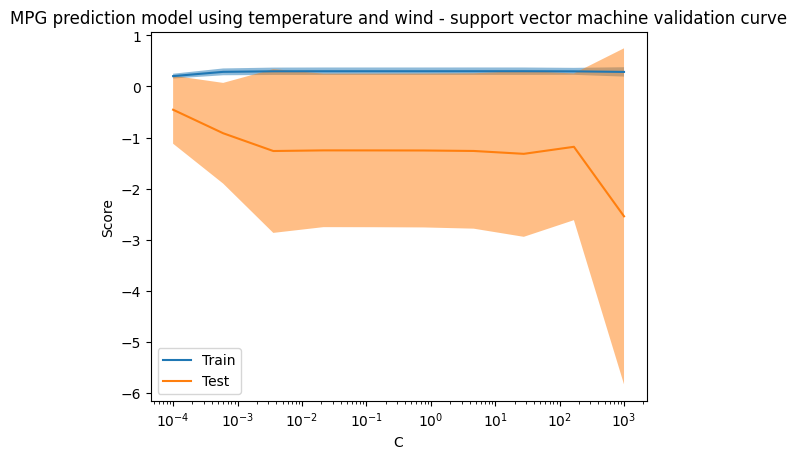

In [26]:
ValidationCurveDisplay.from_estimator(SVR(kernel="linear"), wot_16, mpg_16, param_name="C", param_range=np.logspace(-4, 3, 10), n_jobs = 4,)
plt.title('MPG prediction model using temperature and wind - support vector machine validation curve')
plt.show()

A C value between 10E-3 and 10E2 should perform about the same for the SVR model with temperature and wind as predictors. Perhaps adding tire season will improve the prediction. 

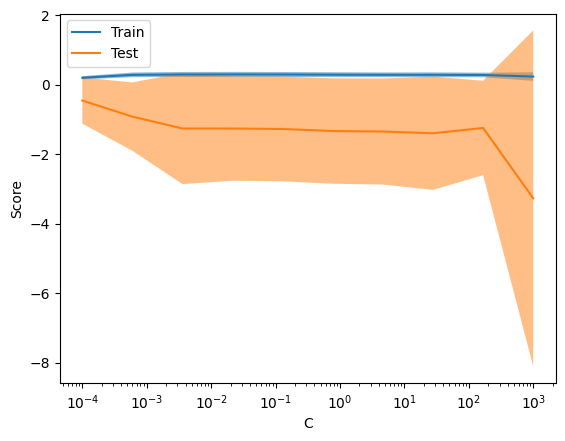

In [27]:
# Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].
ValidationCurveDisplay.from_estimator(SVR(kernel = 'linear'), wt_16, mpg_16, param_name="C", param_range=np.logspace(-4, 3, 10), n_jobs = 4,) 
plt.show()

Adding the tire season to the model improves prediction accuracy slightly, so we'll include it in the full model. A C paramater value of 0.1 (10E-1) will be used since it's in the middle of the accurate range. 

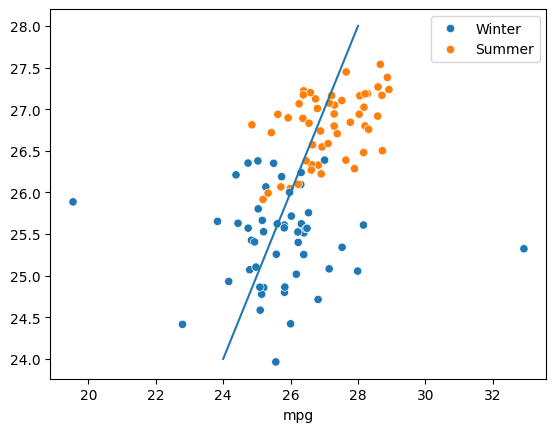

proportion of predictions within 1 standard deviation from the mean: 0.8155339805825242
proportion of predictions within 2 standard deviations from the mean: 0.9805825242718447
proportion of predictions within 3 standard deviations from the mean: 0.9805825242718447
Correlation coefficient for observed vs. predicted mpg: 0.445
Beta values for tire season, temperature (F), and wind speed (mph): [[-0.29146299  0.04027135  0.02404342]]
Score for SVR model given the test data (2017 mpg, temperature, wind): 0.1509


In [28]:
# Using 2016 data to build the model
mod_mach = SVR(kernel = 'linear', C = 10E-1).fit(X = wt_16, y = mpg_16)

# 2017 data is used to test the model
outP = mod_mach.predict(Econ_w[['tire_season_w','TMID', 'AWND']].to_numpy())

plt.close()
sns.scatterplot(x=Econ_w['mpg'], y=outP, hue = Econ_w['tire_season'])
sns.lineplot(x=range(24,29), y=range(24,29))
plt.show()

delta = abs(Econ_w['mpg'] - outP)

print(f'proportion of predictions within 1 standard deviation from the mean:', sum(delta < mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 2 standard deviations from the mean:', sum(delta < 2 * mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 3 standard deviations from the mean:',sum(delta < 3 * mpg_sd)/Econ_w.shape[0])

print(f'Correlation coefficient for observed vs. predicted mpg:',round(np.corrcoef(Econ_w['mpg'], outP)[0,1],3))
print(f'Beta values for tire season, temperature (F), and wind speed (mph):',mod_mach.coef_)
print(f'Score for SVR model given the test data (2017 mpg, temperature, wind):',round(mod_mach.score(Econ_w[['tire_season_w','TMID', 'AWND']].to_numpy(),Econ_w['mpg']),4))

Even though the observed vs. predicted correlation is only slightly higher (0.424 vs 0.445) than the OLS model with the same predictors, the model does appear to be more accurate. 74.7% of the predictions were within 1 standard deviation for the OLS model, compared to 81.6% using SVR. 

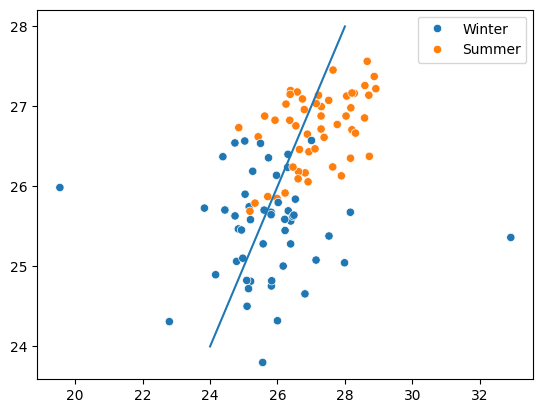

proportion of predictions within 1 standard deviation from the mean: 0.8058252427184466
proportion of predictions within 2 standard deviations from the mean: 0.9805825242718447
proportion of predictions within 3 standard deviations from the mean: 0.9805825242718447
Correlation coefficient for observed vs. predicted mpg: 0.423
Beta values for temperature (F), and wind speed (mph): [[0.04631167 0.02616791]]
Score for SVR model given the test data (2017 mpg, temperature, wind): 0.1237


In [29]:
# using 2016 data to build the model
mod_mach = SVR(kernel = 'linear', C = 10E-1).fit(X = wot_16, y = mpg_16)

# 2017 data is used to test the model
outP = mod_mach.predict(wot_17)

plt.close()
sns.scatterplot(x=mpg_17, y=outP, hue = Econ_w['tire_season'])
sns.lineplot(x=range(24,29), y=range(24,29))
plt.show()

delta = abs(mpg_17 - outP)

print(f'proportion of predictions within 1 standard deviation from the mean:', sum(delta < mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 2 standard deviations from the mean:', sum(delta < 2 * mpg_sd)/Econ_w.shape[0])
print(f'proportion of predictions within 3 standard deviations from the mean:',sum(delta < 3 * mpg_sd)/Econ_w.shape[0])

print(f'Correlation coefficient for observed vs. predicted mpg:',round(np.corrcoef(Econ_w['mpg'], outP)[0,1],3))
print(f'Beta values for temperature (F), and wind speed (mph):',mod_mach.coef_)
print(f'Score for SVR model given the test data (2017 mpg, temperature, wind):',round(mod_mach.score(Econ_w[['TMID', 'AWND']].to_numpy(),Econ_w['mpg']),4))

With or without tire season is not taken into account, the SVR model performs similarly. How do the SVR and OLS models compare to simply assuming the mean value? 

In [30]:
avg_mpg = np.mean(Econ16_w['mpg'])
mean_diff = abs(avg_mpg - Econ_w['mpg'])

print(sum(mean_diff < mpg_sd)/Econ_w.shape[0])
print(sum(mean_diff < 2 * mpg_sd)/Econ_w.shape[0])
print(sum(mean_diff < 3 * mpg_sd)/Econ_w.shape[0])

0.7572815533980582
0.970873786407767
0.9805825242718447


The best OLS model is slightly improved over assuming the mean value for fuel economy (77.7% from 75.7%). The best SVR model is more of an improvement, with almost 6% more predictions within 1 sd of the observed value (81.6% from 75.7%).

### Limitations:
Fuel economy can be predicted more accurately using local weather compared to assuming the mean value. However, the predictive power is limited, likely by a few factors. Weather data is not based on the time of day of travel, so factors like wind speed and temperature are not accurately measured. This can lead to the effects of temperature and wind being underestimated and attributed to another variable. Another limitation is that the way fuel economy is measured relies on the assumption that the tank is filled to the same level each time. This isn't always the case as sometimes I'd 'top-off' the tank, or only get a partial tank. Average Vehicle speed was also not recorded, as well as idle time, and stops. All of those are going to have a significant impact on fuel economy, limiting the accuracy of the predictions. 

### Conclusion:
Fuel Economy can be accurately predicted using temperature and wind data, with 81.6% of the predictions within 1 standard deviation from the observed value. Most of the predictive power is associated with temperature, as the estimated p-value (using OLS) is 9.3E-4 for daily temperature given tire season and average wind speed. When tire season is not considered using OLS, the prediction accuracy increases by 3%. However, when comparing the SVR models, prediction accuracy is decreased by about 1% if tire season is not considered. This could be because the contribution of tire season on fuel economy is partially captured in the average temperature variable. Tire season may not affect fuel economy, and the seasonal effects are far better explained by temperature and wind. 